In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
f = open('gFunctions.pcl','rb')
gSTAR = pickle.load(f)
gSTARS = pickle.load(f)
Tfunc = pickle.load(f)
f.close()

INFO:pyCode.AuxFuncs:Loading aux functions. Ignoring BSM corrections to g* and g*_S


In [3]:
def gammaSigmaV(T,n,neq,g,mass):
    sV = g**2*np.exp(-mass/T)/(T*mass)
#     Gamma = sV*n*(neq**2/n**2 - 1.)
    Gamma = sV*n
    return Gamma

def gammaConvertionRate(T,ni,nieq,nj,njeq,g,mass,dmass):
    conv = g**2*np.exp(-dmass/T)*T**2/mass
#     Gamma = conv*(nieq*nj/(ni*njeq) - 1.)
    Gamma = conv
    return Gamma

def Hf(T):
    MP = 1.22*10**19
    rhoRad = (np.pi**2/30)*gSTAR(T)*T** 4  # thermal bath's energy density    
    H = np.sqrt(8*np.pi*rhoRad/3)/MP
    
    return H

def nEQf(T,dof,mass):
    """Returns the equilibrium number density at temperature T. Returns zero for non-thermal components"""

    Zeta3 = zetac(3.) + 1.

    x = T/mass
    if x < 0.1:
        neq = mass**3*(x/(2*np.pi))**(3./2.)*np.exp(-1/x)*(1. + (15./8.)*x + (105./128.)*x**2) #Non-relativistic
    elif x < 1.5:            
        neq = mass**3*x*kn(2,1/x)/(2*np.pi**2) #Non-relativistic/relativistic
    else:
        if dof > 0: neq = Zeta3*T**3/np.pi**2   #Relativistic Bosons
        if dof < 0: neq = (3./4.)*Zeta3*T**3/np.pi**2   #Relativistic Fermions

    neq = neq*abs(dof)
    return neq

def invDecayF(ni,nieq,nj,njeq,width):
    
    gDec = width*nieq*nj/(njeq*ni)
    return gDec
    

gSigmaV = np.vectorize(gammaSigmaV)
gConv = np.vectorize(gammaConvertionRate)
H = np.vectorize(Hf)
nEQ = np.vectorize(nEQf)
gs = np.vectorize(gSTARS)
invDecay = np.vectorize(invDecayF)

In [4]:
with open('result_noCRate.dat','r') as f:
    omega = eval([l for l in f.readlines() if 'DM' in l and l[0] == '#'][0].split('Omega h^2 (@TF) =')[-1])

In [5]:
skiplines = 10
d = np.genfromtxt('result_noCRate.dat',names=True,skip_header=skiplines)

In [6]:
print(d.dtype.names)

('x', 'T', 'R', 'S', 'n_DM', 'rho_DM', 'n_Mediator', 'rho_Mediator')


In [7]:
newtype = np.dtype(d.dtype.descr + [('H', '<f8'),('s','<f8'),('neq_DM', '<f8'),('neq_Mediator', '<f8')])
newdata = np.zeros(d.shape, dtype=newtype)
for name in d.dtype.names:
    newdata[name] = d[name]
newdata['H'] = H(d['T'])
newdata['s'] = gs(d['T'])*(d['T']**3)
newdata['neq_DM'] = nEQ(d['T'],-2,500.)
newdata['neq_Mediator'] = nEQ(d['T'],6,510.)
d = newdata

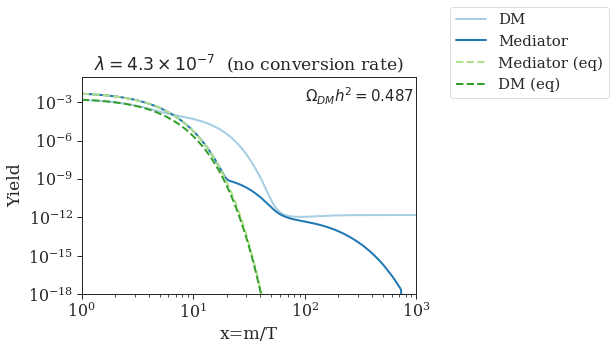

In [8]:
plt.plot(500./d['T'],d['n_DM']/d['s'],label='DM',linewidth=2)
plt.plot(500./d['T'],d['n_Mediator']/d['s'],label='Mediator',linewidth=2)
plt.plot(500./d['T'],d['neq_Mediator']/d['s'],'--',label='Mediator (eq)',linewidth=2)
plt.plot(500./d['T'],d['neq_DM']/d['s'],'--',label='DM (eq)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
plt.ylim(1e-18,1e-1)
plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\lambda = 4.3\times 10^{-7}$  (no conversion rate)')
plt.text(100.,1e-3,s=r'$\Omega_{DM} h^2 = %1.3g$' %omega,fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [9]:
with open('result_CDFO.dat','r') as f:
    omega = eval([l for l in f.readlines() if 'DM' in l and l[0] == '#'][0].split('Omega h^2 (@TF) =')[-1])

In [10]:
skiplines = 10
d = np.genfromtxt('result_CDFO.dat',names=True,skip_header=skiplines)
newtype = np.dtype(d.dtype.descr + [('H', '<f8'),('s','<f8'),('neq_DM', '<f8'),('neq_Mediator', '<f8')])
newdata = np.zeros(d.shape, dtype=newtype)
for name in d.dtype.names:
    newdata[name] = d[name]
newdata['H'] = H(d['T'])
newdata['s'] = gs(d['T'])*(d['T']**3)
newdata['neq_DM'] = nEQ(d['T'],-2,500.)
newdata['neq_Mediator'] = nEQ(d['T'],6,510.)
d = newdata

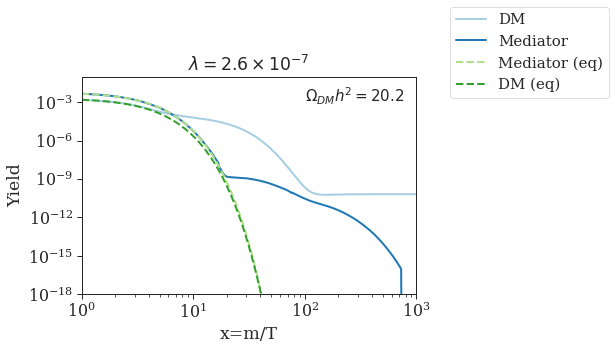

In [11]:
plt.plot(500./d['T'],d['n_DM']/d['s'],label='DM',linewidth=2)
plt.plot(500./d['T'],d['n_Mediator']/d['s'],label='Mediator',linewidth=2)
plt.plot(500./d['T'],d['neq_Mediator']/d['s'],'--',label='Mediator (eq)',linewidth=2)
plt.plot(500./d['T'],d['neq_DM']/d['s'],'--',label='DM (eq)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
plt.ylim(1e-18,1e-1)
plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.title(r'$\lambda = 2.6\times 10^{-7}$')
plt.text(100.,1e-3,s=r'$\Omega_{DM} h^2 = %1.3g$' %omega,fontsize=15)
# plt.savefig("Yield_withConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()